In [1]:
#Generate plot 1 showing the efect of moments on the temp distribution.
# d = daily, pi= pre-industrial, eoc= end-of-century

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
import numbers
#np.set_printoptions(threshold=np.inf)
from scipy.special import erfinv, erf
import xskillscore as xs

In [3]:
def gauss_quantile(mean,std,quantile):
    #quantile must be a real number neteoceen 0 and 1
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue
    

In [4]:
#Chicago
LAT1        = 41.8781
LON1        = (360-87.6298)%360
#Boston
# LAT          = 42.3601
# LON          = (360-71.0589)%360
# #Bengaluru:
LAT2        = 12.9716
LON2        = 77.5946
#Berkeley
# LAT       = 37.8715
# LON       = (360-122.2730)%360
savefigs   = '/global/scratch/users/harsha/savefigs/Feb21/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
cvals_det  = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
loc1       = 'Chicago/'
locn1      = 'Chicago'
loc2       = 'Bengaluru/'
locn2      = 'Bengaluru'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
print(LAT1,LON1)
print(LAT2,LON2)

41.8781 272.3702
12.9716 77.5946


In [5]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [6]:
def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.

    Parameters
    ----------
    x, y : array-like
        One-dimensional numeric arrays.

    ax : matplotlib.axes.Axes, optional
        Axes on which to plot. If not provided, the current axes will be used.

    quantiles : int or array-like, optional
        Quantiles to include in the plot. This can be an array of quantiles, in
        which case only the specified quantiles of `x` and `y` will be plotted.
        If this is an int `n`, then the quantiles will be `n` evenly spaced
        points between 0 and 1. If this is None, then `min(len(x), len(y))`
        evenly spaced quantiles between 0 and 1 will be computed.

    interpolation : {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
        Specify the interpolation method used to find quantiles when `quantiles`
        is an int or None. See the documentation for numpy.quantile().

    rug : bool, optional
        If True, draw a rug plot representing both samples on the horizontal and
        vertical axes. If False, no rug plot is drawn.

    rug_length : float in [0, 1], optional
        Specifies the length of the rug plot lines as a fraction of the total
        vertical or horizontal length.

    rug_kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
        matplotlib.axes.Axes.axhline() when drawing rug plots.

    kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
        the q-q plot.
    """
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)

    # Draw the rug plots if requested
    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)


In [7]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(3)

In [8]:
cluster

Dashboard: http://10.0.39.12:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.39.12:43250,Workers: 0
Dashboard: http://10.0.39.12:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
pi_year  = 1865
eoc_year = 2085
doy      =  211# day_of_year #211 = Jul 30
date     = 'Jul30'

In [10]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 3.36 s, sys: 556 ms, total: 3.91 s
Wall time: 3.9 s


In [11]:
%%time
#Close to (LAT, LON) ;t-temp, pi - no-warming, w-warming

teoc_loc1  = ds_ssp.TREFHTMX.sel(lat=LAT1,lon=LON1,method='nearest',\
         time=ds_ssp.time.dt.dayofyear==doy).sel(time=slice(ic_year0,ic_year1))
teoc_loc2  = ds_ssp.TREFHTMX.sel(lat=LAT2,lon=LON2,method='nearest',\
         time=ds_ssp.time.dt.dayofyear==doy).sel(time=slice(ic_year0,ic_year1))

tpi_loc1 = ds_hist.TREFHTMX.sel(lat=LAT1,lon=LON1,method='nearest',\
         time=ds_hist.time.dt.dayofyear==doy).sel(time=slice(pi_year0,pi_year1))
tpi_loc2 = ds_hist.TREFHTMX.sel(lat=LAT2,lon=LON2,method='nearest',\
         time=ds_hist.time.dt.dayofyear==doy).sel(time=slice(pi_year0,pi_year1))
tpi_loc2

CPU times: user 3.12 s, sys: 160 ms, total: 3.28 s
Wall time: 3.16 s


<xarray.DataArray 'TREFHTMX' (time: 30, member: 100)>
dask.array<getitem, shape=(30, 100), dtype=float32, chunksize=(10, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 12.72
    lon      float64 77.5
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * time     (time) object 1850-07-30 00:00:00 ... 1879-07-30 00:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [12]:
##### Convert to daily data ##############
tdpi_loc1   = to_daily(tpi_loc1)
tdpi_loc2   = to_daily(tpi_loc2)
tdeoc_loc1  = to_daily(teoc_loc1)
tdeoc_loc2  = to_daily(teoc_loc2)
#
tdpi_loc1   = tdpi_loc1.sel(day=doy)
tdpi_loc2   = tdpi_loc2.sel(day=doy)
tdeoc_loc1  = tdeoc_loc1.sel(day=doy)
tdeoc_loc2  = tdeoc_loc2.sel(day=doy)
#tdpi_loc1

In [13]:
#### Fit a line to the ensemble mean data #####
pcoeffs_deocloc1  = tdeoc_loc1.mean('member').polyfit(dim='year',deg=1)
pcoeffs_deocloc2  = tdeoc_loc2.mean('member').polyfit(dim='year',deg=1)
pcoeffs_dpiloc1   = tdpi_loc1.mean('member').polyfit(dim='year',deg=1)
pcoeffs_dpiloc2   = tdpi_loc2.mean('member').polyfit(dim='year',deg=1)

In [14]:
%%time
m_deocloc1     = pcoeffs_deocloc1.polyfit_coefficients.sel(degree=1)
m_deocloc2     = pcoeffs_deocloc2.polyfit_coefficients.sel(degree=1)
#
m_dpiloc1    = pcoeffs_dpiloc1.polyfit_coefficients.sel(degree=1)
m_dpiloc2    = pcoeffs_dpiloc2.polyfit_coefficients.sel(degree=1)
# m_dpiloc1.values

CPU times: user 24.6 ms, sys: 2.44 ms, total: 27.1 ms
Wall time: 24.6 ms


In [15]:
#####Construct the trend line m*(y-y0) eochere y0 =1865 or 2071
pi_trendloc1   = m_dpiloc1*(tdpi_loc1['year']  - pi_year)
pi_trendloc2   = m_dpiloc2*(tdpi_loc2['year']  - pi_year)
eoc_trendloc1  = m_deocloc1*(tdeoc_loc1['year']- eoc_year)
eoc_trendloc2  = m_deocloc2*(tdeoc_loc2['year']- eoc_year)
##### Subtract trend from data ########
tpi_loc1_det   = tdpi_loc1  -  pi_trendloc1
tpi_loc2_det   = tdpi_loc2  -  pi_trendloc2
teoc_loc1_det  = tdeoc_loc1 - eoc_trendloc1
teoc_loc2_det  = tdeoc_loc2 - eoc_trendloc2

In [16]:
print(pi_trendloc1.values,eoc_trendloc1.values)

[ 0.16040935  0.1497154   0.13902144  0.12832748  0.11763353  0.10693957
  0.09624561  0.08555165  0.0748577   0.06416374  0.05346978  0.04277583
  0.03208187  0.02138791  0.01069396 -0.         -0.01069396 -0.02138791
 -0.03208187 -0.04277583 -0.05346978 -0.06416374 -0.0748577  -0.08555165
 -0.09624561 -0.10693957 -0.11763353 -0.12832748 -0.13902144 -0.1497154 ] [-0.97360089 -0.90405797 -0.83451505 -0.76497213 -0.69542921 -0.62588629
 -0.55634337 -0.48680044 -0.41725752 -0.3477146  -0.27817168 -0.20862876
 -0.13908584 -0.06954292  0.          0.06954292  0.13908584  0.20862876
  0.27817168  0.3477146   0.41725752  0.48680044  0.55634337  0.62588629
  0.69542921  0.76497213  0.83451505  0.90405797  0.97360089  1.04314381]


In [17]:
%%time
tpi_loc1_det   = tpi_loc1_det.stack(mtime=('member','year'),create_index=False)
teoc_loc1_det  = teoc_loc1_det.stack(mtime=('member','year'),create_index=False)
#
tpi_loc2_det   = tpi_loc2_det.stack(mtime=('member','year'),create_index=False)
teoc_loc2_det  = teoc_loc2_det.stack(mtime=('member','year'),create_index=False)
#teoc_loc1_det

CPU times: user 54.4 ms, sys: 6.46 ms, total: 60.8 ms
Wall time: 52.7 ms


In [18]:
# Save daily,local tmax, mc = mean corrected, msc = mean and std-corrected
tmc_loc1_det  = (tpi_loc1_det - tpi_loc1_det.mean())+teoc_loc1_det.mean()
tmsc_loc1_det = (tpi_loc1_det - tpi_loc1_det.mean())*(teoc_loc1_det.std()/tpi_loc1_det.std()) + teoc_loc1_det.mean()
#
tmc_loc2_det  = (tpi_loc2_det - tpi_loc2_det.mean())+teoc_loc2_det.mean()
tmsc_loc2_det = (tpi_loc2_det - tpi_loc2_det.mean())*(teoc_loc2_det.std()/tpi_loc2_det.std()) + teoc_loc2_det.mean()
# Check if the transformation is correct
# tmc_loc1_det.mean().values - teoc_loc1_det.mean().values

In [19]:
# Set paths for detrended local tmax - warming, no warming and corrected.
dpi_detpath1      = cvals_det+loc1+'tpi_det'+date+'_'+pi_year0+'_'+pi_year1+'_loc.zarr'
deoc_detpath1     = cvals_det+loc1+'teoc_det'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmsc_detpath1     = cvals_det+loc1+'tmsc_det'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmc_detpath1      = cvals_det+loc1+'tmc_det'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
#
dpi_detpath2      = cvals_det+loc2+'tpi_det'+date+'_'+pi_year0+'_'+pi_year1+'_loc.zarr'
deoc_detpath2     = cvals_det+loc2+'teoc_det'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmsc_detpath2     = cvals_det+loc2+'tmsc_det'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmc_detpath2      = cvals_det+loc2+'tmc_det'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
print(dpi_detpath1) 

/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/Chicago/tpi_detJul30_1850_1879_loc.zarr


In [20]:
print(tpi_loc1_det.mean().values,tpi_loc1_det.std().values)
print(tdpi_loc1.mean().values,tdpi_loc1.std().values)

305.17810541416463 3.828576665458247
305.18347 3.8296955


In [22]:
# print(teoc_loc1_det.mean().values,teoc_loc1_det.std().values)
# print(tdeoc_loc1.mean().values,tdeoc_loc1.std().values)

In [23]:
# print(tpi_loc2_det.mean().values,tpi_loc2_det.std().values)
# print(tdpi_loc2.mean().values,tdpi_loc2.std().values)

In [24]:
# print(teoc_loc2_det.mean().values,teoc_loc2_det.std().values)
# print(tdeoc_loc2.mean().values,tdeoc_loc2.std().values)

In [25]:
%%time
#### Save detreneded data #####
tpi_loc1_det    = tpi_loc1_det.chunk(dict(mtime=-1)).rename('detrended_tmax')
teoc_loc1_det   = teoc_loc1_det.chunk(dict(mtime=-1)).rename('detrended_tmax')
tmc_loc1_det    = tmc_loc1_det.chunk(dict(mtime=-1)).rename('detrended_tmax')
tmsc_loc1_det   = tmsc_loc1_det.chunk(dict(mtime=-1)).rename('detrended_tmax')
#
tpi_loc2_det    = tpi_loc2_det.chunk(dict(mtime=-1)).rename('detrended_tmax')
teoc_loc2_det   = teoc_loc2_det.chunk(dict(mtime=-1)).rename('detrended_tmax')
tmc_loc2_det    = tmc_loc2_det.chunk(dict(mtime=-1)).rename('detrended_tmax')
tmsc_loc2_det   = tmsc_loc2_det.chunk(dict(mtime=-1)).rename('detrended_tmax')
#
# tpi_loc1_det.to_dataset().to_zarr(dpi_detpath1,mode='w')
# teoc_loc1_det.to_dataset().to_zarr(deoc_detpath1,mode='w')
# tmc_loc1_det.to_dataset().to_zarr(dmc_detpath1,mode='w')
# tmsc_loc1_det.to_dataset().to_zarr(dmsc_detpath1,mode='w')

# tpi_loc2_det.to_dataset().to_zarr(dpi_detpath2,mode='w')
# teoc_loc2_det.to_dataset().to_zarr(deoc_detpath2,mode='w')
# tmc_loc2_det.to_dataset().to_zarr(dmc_detpath2,mode='w')
# tmsc_loc2_det.to_dataset().to_zarr(dmsc_detpath2,mode='w')

CPU times: user 158 ms, sys: 7.08 ms, total: 165 ms
Wall time: 158 ms


In [26]:
%%time
tpi_loc1_det     = xr.open_zarr(dpi_detpath1).detrended_tmax
teoc_loc1_det    = xr.open_zarr(deoc_detpath1).detrended_tmax
tmc_loc1_det     = xr.open_zarr(dmc_detpath1).detrended_tmax
tmsc_loc1_det    = xr.open_zarr(dmsc_detpath1).detrended_tmax
#
tpi_loc2_det     = xr.open_zarr(dpi_detpath2).detrended_tmax
teoc_loc2_det    = xr.open_zarr(deoc_detpath2).detrended_tmax
tmc_loc2_det     = xr.open_zarr(dmc_detpath2).detrended_tmax
tmsc_loc2_det    = xr.open_zarr(dmsc_detpath2).detrended_tmax

CPU times: user 795 ms, sys: 66.8 ms, total: 862 ms
Wall time: 821 ms


In [27]:
# Get the Gaussian candidate distrubutions for the EOC period.
quants      = np.arange(0.01,1.00,0.01)
#
qeocgauss_loc1_det = gauss_quantile(teoc_loc1_det.mean().values,teoc_loc1_det.std().values,quants)
qeocgauss_loc1_det = xr.DataArray(qeocgauss_loc1_det, coords={'quantile': quants}, dims=["quantile"])
#
qpigauss_loc1_det  = gauss_quantile(tpi_loc1_det.mean().values,tpi_loc1_det.std().values,quants)
qpigauss_loc1_det  = xr.DataArray(qpigauss_loc1_det, coords={'quantile': quants}, dims=["quantile"])
#
qeocgauss_loc2_det  = gauss_quantile(teoc_loc2_det.mean().values,teoc_loc2_det.std().values,quants)
qeocgauss_loc2_det  = xr.DataArray(qeocgauss_loc2_det, coords={'quantile': quants}, dims=["quantile"])
#
qpigauss_loc2_det   = gauss_quantile(tpi_loc2_det.mean().values,tpi_loc2_det.std().values,quants)
qpigauss_loc2_det   = xr.DataArray(qpigauss_loc2_det, coords={'quantile': quants}, dims=["quantile"])

In [28]:
%%time
#Compute quantile function - Jan 1 tmax
qpi_loc1_det   = tpi_loc1_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qeoc_loc1_det  = teoc_loc1_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qmc_loc1_det   = tmc_loc1_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qmsc_loc1_det  = tmsc_loc1_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
#
qpi_loc2_det   = tpi_loc2_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qeoc_loc2_det  = teoc_loc2_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qmc_loc2_det   = tmc_loc2_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qmsc_loc2_det  = tmsc_loc2_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')

CPU times: user 1.35 s, sys: 67.1 ms, total: 1.41 s
Wall time: 1.37 s


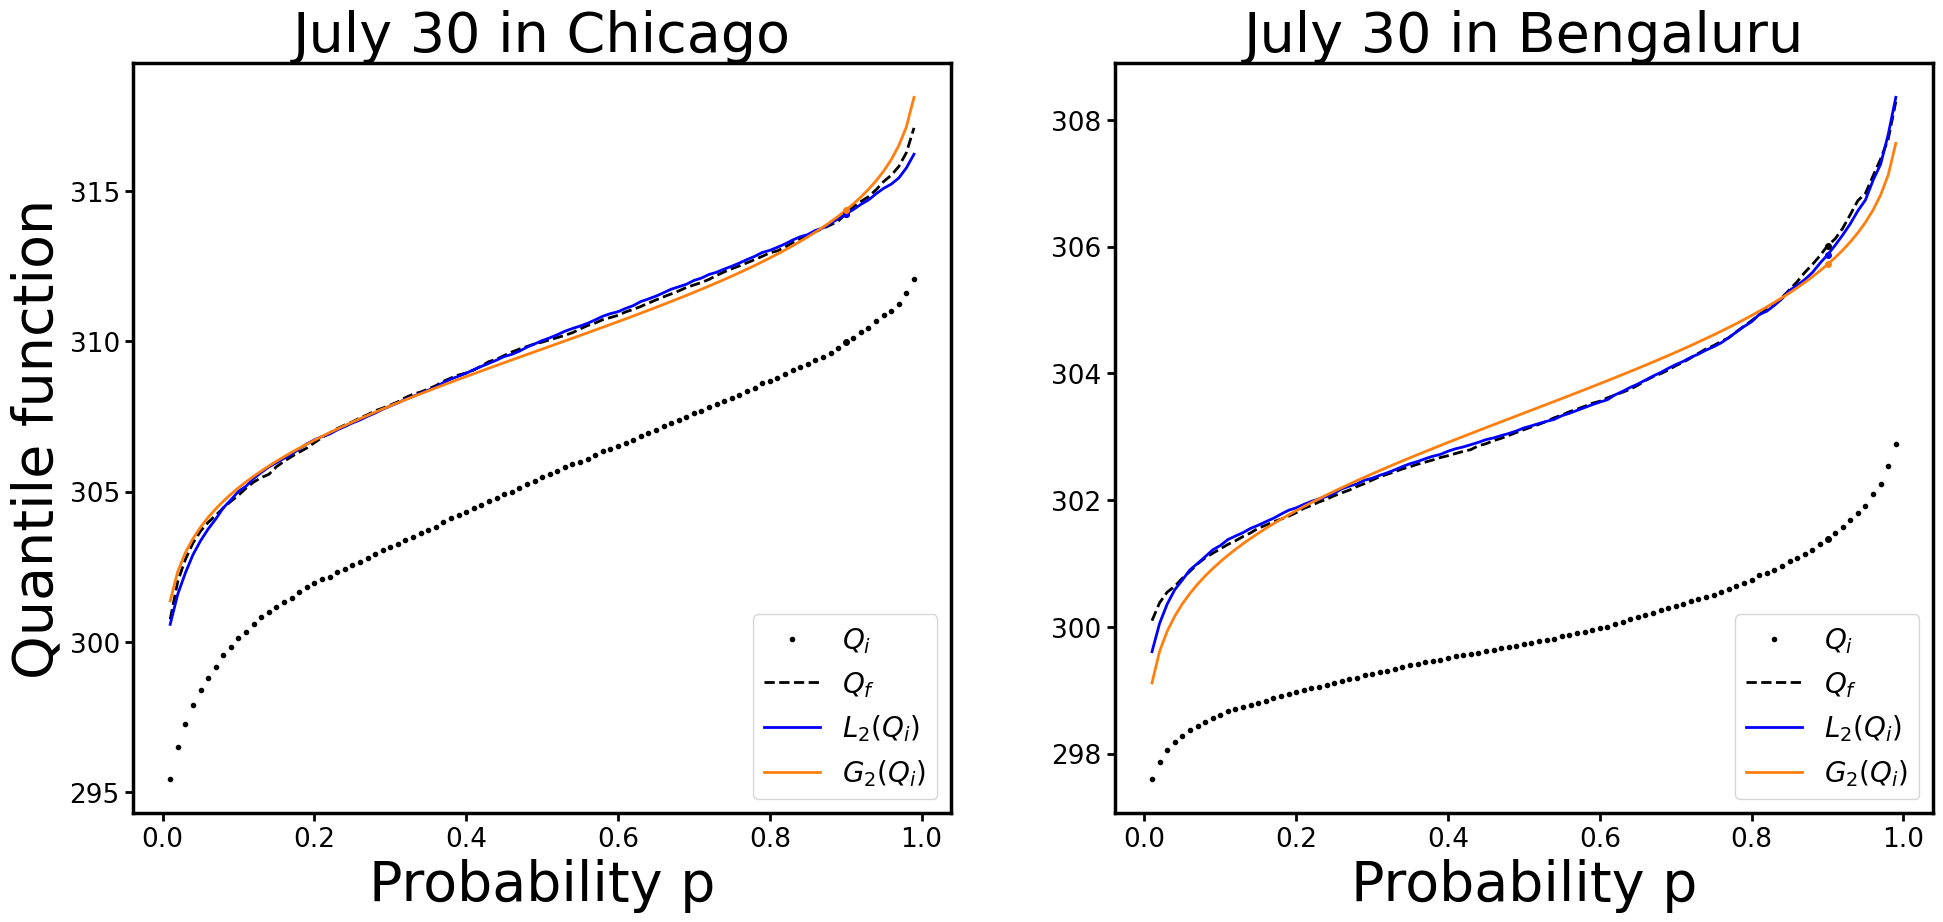

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x2abf6b7e8370>>
Traceback (most recent call last):
  File "/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/utils_perf.py", line 183, in _gc_callback
    self._fractional_timer.start_timing()
  File "/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/utils_perf.py", line 118, in start_timing
    assert self._cur_start is None
AssertionError: 


In [35]:
# Setting up the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10)) # 2 plots - side by side

#Plotting for loc1
axs[0].plot(quants,qpi_loc1_det,'.',color='k',label= r'$Q_i$',lw=2)
axs[0].plot(quants,qeoc_loc1_det,'k--',label=r'$Q_f$',lw=2)
axs[0].plot(quants,qmsc_loc1_det,color='blue',label=r'$L_2(Q_i)$',lw=2)
axs[0].plot(quants,qeocgauss_loc1_det,color='tab:orange',label=r'$G_2(Q_i)$',lw=2)
# Markers for loc1
axs[0].plot(0.9,qeoc_loc1_det.sel(quantile=0.9),marker='o', markerfacecolor='k',\
         markeredgecolor='k', lw=2.3, ms=3, mew=2, color='k')
axs[0].plot(0.9,qpi_loc1_det.sel(quantile=0.9),marker='o',markerfacecolor='k',\
         markeredgecolor='k', lw=2.3, ms=3, mew=2, color='k')
axs[0].plot(0.9,qmsc_loc1_det.sel(quantile=0.9),marker='o',markerfacecolor='blue',\
         markeredgecolor='blue', lw=2.3, ms=3, mew=2, color='blue')
axs[0].plot(0.9,qeocgauss_loc1_det.sel(quantile=0.9),marker='o',markerfacecolor='tab:orange',\
         markeredgecolor='tab:orange', lw=2.3, ms=3, mew=2, color='tab:orange')
axs[0].legend(loc='lower right',prop={'size': 20})
axs[0].set_title('July 30 in '+locn1,fontweight=500,fontsize=40)
axs[0].set_ylabel('Quantile function',fontweight=500,fontsize=40)
axs[0].set_xlabel('Probability p',fontweight=500,fontsize=40)

# Assuming you have similar data for loc2, here is how you would plot it
# Replace qdpi_loc2, qdmsc_loc2, etc. with your actual data variables for loc2

axs[1].plot(quants,qpi_loc2_det,'.',color='k',label= r'$Q_i$',lw=2)
axs[1].plot(quants,qeoc_loc2_det,'k--',label=r'$Q_f$',lw=2)
axs[1].plot(quants,qmsc_loc2_det,'blue',label=r'$L_2(Q_i)$',lw=2)
axs[1].plot(quants,qeocgauss_loc2_det,'tab:orange',label=r'$G_2(Q_i)$',lw=2)
# Markers for loc2
axs[1].plot(0.9,qeoc_loc2_det.sel(quantile=0.9),marker='o', markerfacecolor='k',\
         markeredgecolor='k', lw=2.3, ms=3, mew=2, color='k')
axs[1].plot(0.9,qpi_loc2_det.sel(quantile=0.9),marker='o',markerfacecolor='k',\
         markeredgecolor='k', lw=2.3, ms=3, mew=2, color='k')
axs[1].plot(0.9,qmsc_loc2_det.sel(quantile=0.9),marker='o',markerfacecolor='blue',\
         markeredgecolor='blue', lw=2.3, ms=3, mew=2, color='blue')
axs[1].plot(0.9,qeocgauss_loc2_det.sel(quantile=0.9),marker='o',markerfacecolor='tab:orange',\
         markeredgecolor='tab:orange', lw=2.3, ms=3, mew=2, color='tab:orange')
axs[1].legend(loc='lower right',prop={'size': 20})
axs[1].set_title('July 30 in '+locn2,fontweight=500,fontsize=40)
#axs[1].set_ylabel(date+':Tmax (K)')
axs[1].set_xlabel('Probability p',fontweight=500,fontsize=40)

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.05)
# Finally, display the plots
# plt.tight_layout()
# Adjust tick parameters for both plots
for ax in axs:
    ax.tick_params(width=2.0, length=6, labelsize=19) # adjust width, length and labelsize as desired
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_weight('540')
#normal is 400
# Thicken the borders for both plots
for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)  # Adjust this value for desired border thickness

plt.show()

In [28]:
tpi_loc1_det

<xarray.DataArray 'detrended_tmax' (mtime: 3000)>
dask.array<open_dataset-d07a3af7d3e28666c9bb9a40ef8cba0bdetrended_tmax, shape=(3000,), dtype=float64, chunksize=(3000,), chunktype=numpy.ndarray>
Coordinates:
    day      int64 ...
    degree   int64 ...
    lat      float64 ...
    lon      float64 ...
    member   (mtime) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    year     (mtime) int64 dask.array<chunksize=(3000,), meta=np.ndarray>
Dimensions without coordinates: mtime

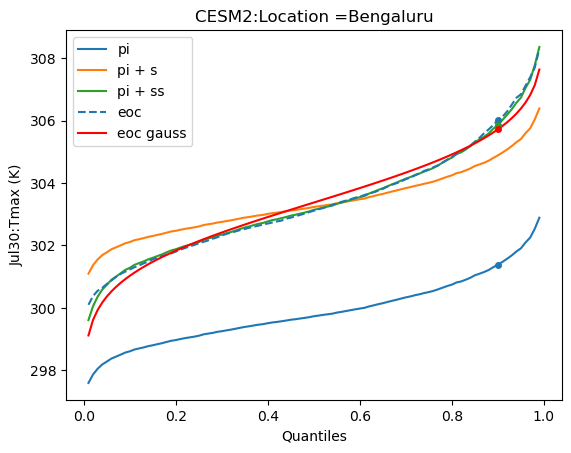

CPU times: user 1.13 s, sys: 118 ms, total: 1.25 s
Wall time: 1.7 s


In [29]:
%%time
plt.plot(quants,qpi_loc2_det,color='tab:blue',label= 'pi')
plt.plot(quants,qmc_loc2_det,color='tab:orange',label= 'pi + s')
plt.plot(quants,qmsc_loc2_det,'tab:green',label='pi + ss')
plt.plot(quants,qeoc_loc2_det,'--',color='tab:blue',label='eoc')
plt.plot(quants,qeocgauss_loc2_det,'red',label='eoc gauss')
# plt.plot(quants,qdpigauss,'tab:red',label='pi gauss')
########### Markers ####################
plt.plot(0.9,qeoc_loc2_det.sel(quantile=0.9),marker='o', markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2, ms=3, mew=2, color='tab:blue')

plt.plot(0.9,qpi_loc2_det.sel(quantile=0.9),marker='o',markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2, ms=3, mew=2, color='tab:blue')

# plt.plot(0.9,qdmc.sel(quantile=0.9),marker='o',markerfacecolor='tab:orange',\
#          markeredgecolor='tab:orange', lw=2, ms=3, mew=2, color='tab:orange')

plt.plot(0.9,qmsc_loc2_det.sel(quantile=0.9),marker='o',markerfacecolor='tab:green',\
         markeredgecolor='tab:green', lw=2, ms=3, mew=2, color='tab:green')

plt.plot(0.9,qeocgauss_loc2_det.sel(quantile=0.9),marker='o',markerfacecolor='red',\
         markeredgecolor='red', lw=2, ms=3, mew=2, color='red')

# plt.plot(0.9,qdpigauss.sel(quantile=0.9),marker='o',markerfacecolor='tab:red',\
#         markeredgecolor='tab:red', lw=2, ms=3, mew=2, color='tab:red')
#############################
#plt.fill_between(quants,qdeoc_ci.sel(quantile=0.025),\
#qdeoc_ci.sel(quantile=0.975),color='b',alpha=0.2)
plt.legend(loc='upper left')
plt.title('CESM2:Location ='+locn2)
plt.ylabel(date+':Tmax (K)')
plt.xlabel('Quantiles')
plt.show()

In [30]:
############################################################################

In [31]:
%%time
# Delete this later !!!!!!!
#d = day/daily
tdpi_loc1   = tpi_loc1.stack(mtime=('member','time'),create_index=False)
tdeoc_loc1  = teoc_loc1.stack(mtime=('member','time'),create_index=False)
#
tdpi_loc2   = tpi_loc2.stack(mtime=('member','time'),create_index=False)
tdeoc_loc2  = teoc_loc2.stack(mtime=('member','time'),create_index=False) 
#
# Save daily,local tmax, mc = mean corrected, msc = mean and std-corrected
tdmc_loc1   = (tdpi_loc1 - tdpi_loc1.mean())+tdeoc_loc1.mean()
tdmsc_loc1  = (tdpi_loc1 - tdpi_loc1.mean())*(tdeoc_loc1.std()/tdpi_loc1.std()) + tdeoc_loc1.mean()
#
tdmc_loc2   = (tdpi_loc2 - tdpi_loc2.mean())+tdeoc_loc2.mean()
tdmsc_loc2  = (tdpi_loc2 - tdpi_loc2.mean())*(tdeoc_loc2.std()/tdpi_loc2.std()) + tdeoc_loc2.mean()
#Check if the transformation is correct
#tdmc.mean().values - tdeoc.mean().values

CPU times: user 92.9 ms, sys: 7.21 ms, total: 100 ms
Wall time: 95.8 ms


In [32]:
%%time
#### Save #####
tdpi_loc1    = tdpi_loc1.chunk(dict(mtime=-1))
tdeoc_loc1   = tdeoc_loc1.chunk(dict(mtime=-1))
tdmc_loc1    = tdmc_loc1.chunk(dict(mtime=-1))
tdmsc_loc1   = tdmsc_loc1.chunk(dict(mtime=-1))
#
tdpi_loc2    = tdpi_loc2.chunk(dict(mtime=-1))
tdeoc_loc2   = tdeoc_loc2.chunk(dict(mtime=-1))
tdmc_loc2    = tdmc_loc2.chunk(dict(mtime=-1))
tdmsc_loc2   = tdmsc_loc2.chunk(dict(mtime=-1))

# tdpi_loc1.to_dataset().to_zarr(dpi_path1,mode='w')
# tdeoc_loc1.to_dataset().to_zarr(deoc_path1,mode='w')
# tdmc_loc1.to_dataset().to_zarr(dmc_path1,mode='w')
# tdmsc_loc1.to_dataset().to_zarr(dmsc_path1,mode='w')

# tdpi_loc2.to_dataset().to_zarr(dpi_path2,mode='w')
# tdeoc_loc2.to_dataset().to_zarr(deoc_path2,mode='w')
# tdmc_loc2.to_dataset().to_zarr(dmc_path2,mode='w')
# tdmsc_loc2.to_dataset().to_zarr(dmsc_path2,mode='w')

CPU times: user 58.2 ms, sys: 6.22 ms, total: 64.4 ms
Wall time: 58.7 ms


In [33]:
# Set paths for local tmax - warming, no warming and corrected.
dpi_path1      = cvals+loc1+'tpi'+date+'_'+pi_year0+'_'+pi_year1+'_loc.zarr'
deoc_path1     = cvals+loc1+'teoc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmsc_path1     = cvals+loc1+'tmsc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmc_path1      = cvals+loc1+'tmc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
#
dpi_path2      = cvals+loc2+'tpi'+date+'_'+pi_year0+'_'+pi_year1+'_loc.zarr'
deoc_path2     = cvals+loc2+'teoc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmsc_path2     = cvals+loc2+'tmsc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmc_path2      = cvals+loc2+'tmc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
print(dpi_path1) 

/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/tpiJul30_1850_1879_loc.zarr


In [34]:
%%time
tdpi_loc1     = xr.open_zarr(dpi_path1).TREFHTMX
tdeoc_loc1    = xr.open_zarr(deoc_path1).TREFHTMX
tdmc_loc1     = xr.open_zarr(dmc_path1).TREFHTMX
tdmsc_loc1    = xr.open_zarr(dmsc_path1).TREFHTMX
#
tdpi_loc2     = xr.open_zarr(dpi_path2).TREFHTMX
tdeoc_loc2    = xr.open_zarr(deoc_path2).TREFHTMX
tdmc_loc2     = xr.open_zarr(dmc_path2).TREFHTMX
tdmsc_loc2    = xr.open_zarr(dmsc_path2).TREFHTMX

CPU times: user 244 ms, sys: 24.6 ms, total: 269 ms
Wall time: 288 ms


In [35]:
# Get the Gaussian candidate distrubutions for the EOC period.
quants      = np.arange(0.01,1.00,0.01)
#
qdeocgauss_loc1  = gauss_quantile(tdeoc_loc1.mean().values,tdeoc_loc1.std().values,quants)
qdeocgauss_loc1  = xr.DataArray(qdeocgauss_loc1, coords={'quantile': quants}, dims=["quantile"])
#
qdpigauss_loc1   = gauss_quantile(tdpi_loc1.mean().values,tdpi_loc1.std().values,quants)
qdpigauss_loc1   = xr.DataArray(qdpigauss_loc1, coords={'quantile': quants}, dims=["quantile"])
#
qdeocgauss_loc2  = gauss_quantile(tdeoc_loc2.mean().values,tdeoc_loc2.std().values,quants)
qdeocgauss_loc2  = xr.DataArray(qdeocgauss_loc2, coords={'quantile': quants}, dims=["quantile"])
#
qdpigauss_loc2   = gauss_quantile(tdpi_loc2.mean().values,tdpi_loc2.std().values,quants)
qdpigauss_loc2   = xr.DataArray(qdpigauss_loc2, coords={'quantile': quants}, dims=["quantile"])

In [36]:
%%time
#Compute quantile function - Jan 1 tmax
qdpi_loc1   = tdpi_loc1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdeoc_loc1  = tdeoc_loc1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmc_loc1   = tdmc_loc1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmsc_loc1  = tdmsc_loc1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
#
qdpi_loc2   = tdpi_loc2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdeoc_loc2  = tdeoc_loc2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmc_loc2   = tdmc_loc2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmsc_loc2  = tdmsc_loc2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')

CPU times: user 458 ms, sys: 17.4 ms, total: 476 ms
Wall time: 461 ms


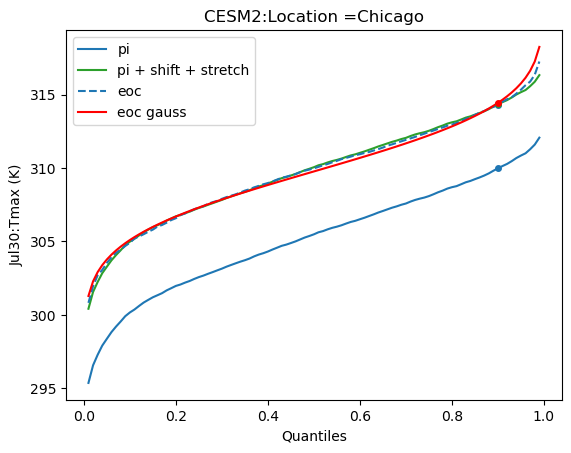

CPU times: user 982 ms, sys: 90.6 ms, total: 1.07 s
Wall time: 1.71 s


In [37]:
%%time
plt.plot(quants,qdpi_loc1,color='tab:blue',label= 'pi')
# plt.plot(quants,qdmc,color='tab:orange',label= 'pi + shift')
plt.plot(quants,qdmsc_loc1,'tab:green',label='pi + shift + stretch')
plt.plot(quants,qdeoc_loc1,'--',color='tab:blue',label='eoc')
plt.plot(quants,qdeocgauss_loc1,'red',label='eoc gauss')
# plt.plot(quants,qdpigauss,'tab:red',label='pi gauss')
########### Markers ####################
plt.plot(0.9,qdeoc_loc1.sel(quantile=0.9),marker='o', markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2, ms=3, mew=2, color='tab:blue')

plt.plot(0.9,qdpi_loc1.sel(quantile=0.9),marker='o',markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2, ms=3, mew=2, color='tab:blue')

# plt.plot(0.9,qdmc.sel(quantile=0.9),marker='o',markerfacecolor='tab:orange',\
#          markeredgecolor='tab:orange', lw=2, ms=3, mew=2, color='tab:orange')

plt.plot(0.9,qdmsc_loc1.sel(quantile=0.9),marker='o',markerfacecolor='tab:green',\
         markeredgecolor='tab:green', lw=2, ms=3, mew=2, color='tab:green')

plt.plot(0.9,qdeocgauss_loc1.sel(quantile=0.9),marker='o',markerfacecolor='red',\
         markeredgecolor='red', lw=2, ms=3, mew=2, color='red')

# plt.plot(0.9,qdpigauss.sel(quantile=0.9),marker='o',markerfacecolor='tab:red',\
#         markeredgecolor='tab:red', lw=2, ms=3, mew=2, color='tab:red')
#############################
#plt.fill_between(quants,qdeoc_ci.sel(quantile=0.025),\
#qdeoc_ci.sel(quantile=0.975),color='b',alpha=0.2)
plt.legend(loc='upper left')
plt.title('CESM2:Location ='+locn1)
plt.ylabel(date+':Tmax (K)')
plt.xlabel('Quantiles')
plt.show()

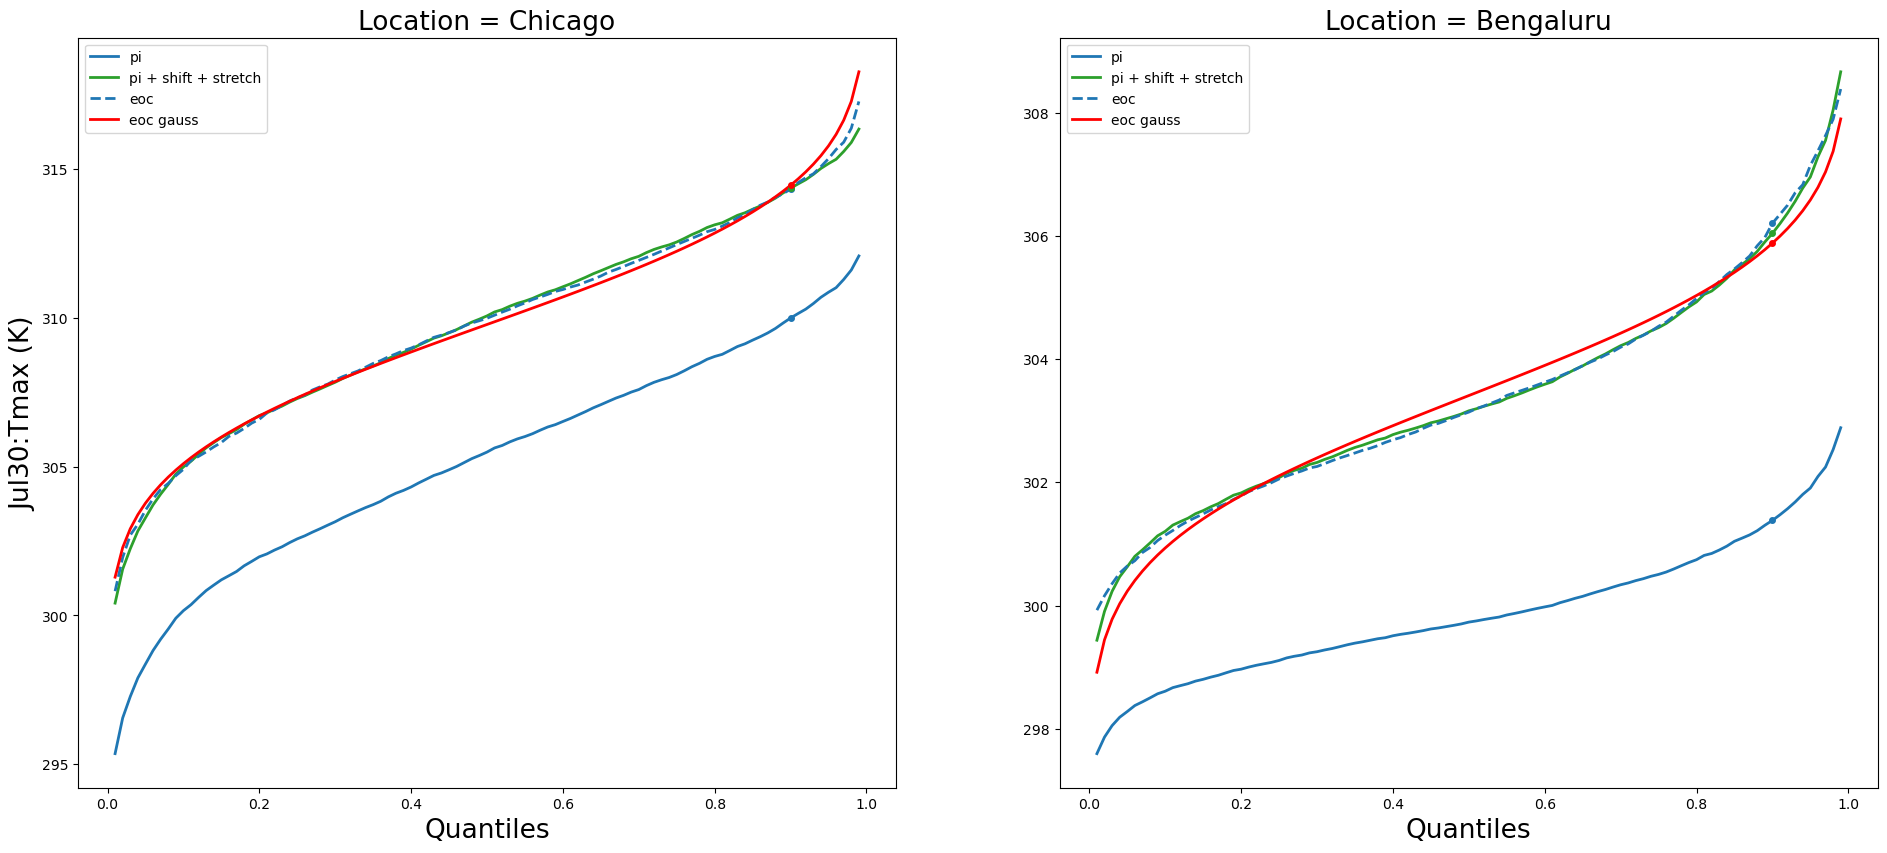

In [38]:
# Setting up the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10)) # 2 plots - side by side

#Plotting for loc1
axs[0].plot(quants,qdpi_loc1,color='tab:blue',label= 'pi',lw=2)
axs[0].plot(quants,qdmsc_loc1,color='tab:green',label='pi + shift + stretch',lw=2)
axs[0].plot(quants,qdeoc_loc1,'--',color='tab:blue',label='eoc',lw=2)
axs[0].plot(quants,qdeocgauss_loc1,'red',label='eoc gauss',lw=2)
# Markers for loc1
axs[0].plot(0.9,qdeoc_loc1.sel(quantile=0.9),marker='o', markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2.3, ms=3, mew=2, color='tab:blue')
axs[0].plot(0.9,qdpi_loc1.sel(quantile=0.9),marker='o',markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2.3, ms=3, mew=2, color='tab:blue')
axs[0].plot(0.9,qdmsc_loc1.sel(quantile=0.9),marker='o',markerfacecolor='tab:green',\
         markeredgecolor='tab:green', lw=2.3, ms=3, mew=2, color='tab:green')
axs[0].plot(0.9,qdeocgauss_loc1.sel(quantile=0.9),marker='o',markerfacecolor='red',\
         markeredgecolor='red', lw=2.3, ms=3, mew=2, color='red')
axs[0].legend(loc='upper left')
axs[0].set_title('Location = '+locn1,fontweight=500,fontsize=19)
axs[0].set_ylabel(date+':Tmax (K)',fontweight=500,fontsize=19)
axs[0].set_xlabel('Quantiles',fontweight=500,fontsize=19)

# Assuming you have similar data for loc2, here is how you would plot it
# Replace qdpi_loc2, qdmsc_loc2, etc. with your actual data variables for loc2

axs[1].plot(quants,qdpi_loc2,color='tab:blue',label= 'pi',lw=2)
axs[1].plot(quants,qdmsc_loc2,'tab:green',label='pi + shift + stretch',lw=2)
axs[1].plot(quants,qdeoc_loc2,'--',color='tab:blue',label='eoc',lw=2)
axs[1].plot(quants,qdeocgauss_loc2,'red',label='eoc gauss',lw=2)
# Markers for loc2
axs[1].plot(0.9,qdeoc_loc2.sel(quantile=0.9),marker='o', markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2.3, ms=3, mew=2, color='tab:blue')
axs[1].plot(0.9,qdpi_loc2.sel(quantile=0.9),marker='o',markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2.3, ms=3, mew=2, color='tab:blue')
axs[1].plot(0.9,qdmsc_loc2.sel(quantile=0.9),marker='o',markerfacecolor='tab:green',\
         markeredgecolor='tab:green', lw=2.3, ms=3, mew=2, color='tab:green')
axs[1].plot(0.9,qdeocgauss_loc2.sel(quantile=0.9),marker='o',markerfacecolor='red',\
         markeredgecolor='red', lw=2.3, ms=3, mew=2, color='red')
axs[1].legend(loc='upper left')
axs[1].set_title('Location = '+locn2,fontweight=500,fontsize=19)
#axs[1].set_ylabel(date+':Tmax (K)')
axs[1].set_xlabel('Quantiles',fontweight=500,fontsize=19)

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.05)
# Finally, display the plots
# plt.tight_layout()
plt.show()

In [39]:
%%time
gauss_rmse1    = xs.rmse(qdeocgauss_loc1,qdeoc_loc1)
dmsc_rmse1     = xs.rmse(qdmsc_loc1,qdeoc_loc1)
gauss_detrmse1 = xs.rmse(qeocgauss_loc1_det,qeoc_loc1_det)
dmsc_detrmse1  = xs.rmse(qmsc_loc1_det,qeoc_loc1_det)
print(gauss_rmse1.values,dmsc_rmse1.values)
print(gauss_detrmse1.values,dmsc_detrmse1.values)

0.2508299729993667 0.1676207408443502
0.2507047509554205 0.16937416019874355
CPU times: user 5.77 s, sys: 248 ms, total: 6.02 s
Wall time: 32.4 s


In [40]:
%%time
dmsc_rmse2     = xs.rmse(qdmsc_loc2,qdeoc_loc2)
gauss_rmse2    = xs.rmse(qdeocgauss_loc2,qdeoc_loc2)
gauss_detrmse2 = xs.rmse(qeocgauss_loc2_det,qeoc_loc2_det)
dmsc_detrmse2  = xs.rmse(qmsc_loc2_det,qeoc_loc2_det)
print(gauss_rmse2.values,dmsc_rmse2.values)
print(gauss_detrmse2.values,dmsc_detrmse2.values)

0.2802798468951236 0.08864979733450398
0.2798454709445884 0.08402195680975481
CPU times: user 357 ms, sys: 27.3 ms, total: 384 ms
Wall time: 810 ms


In [41]:
%%time
pigauss_rmse = xs.rmse(qdpigauss,qdpi)
dmc_rmse = xs.rmse(qdmc,qdeoc)
print(dmc_rmse.values,pigauss_rmse.values)

NameError: name 'qdpigauss' is not defined

### <span style ='color:Red'> This is extra code. Please ignore! </span>

In [43]:
# qdeoca  = qdeoc-qdpi
# qdca  = qdc-qdpi #eoc= eocarming, a = anomaly
# qdmca = qdc-qdpi
# qdeoc     = qdeoc.rename({'quantile':'permilles'})
# qdmc    = qdmc.rename({'quantile':'permilles'})
# qdmsc   = qdmsc.rename({'quantile':'permilles'})
# qdpi    = qdpi.rename({'quantile':'permilles'})
# qdgauss = qdgauss.rename({'quantile':'permilles'})

In [44]:
# %%time
# plt.plot(quants,qdpi,'b--',label='pi')
# #plt.plot(quants,qdmc,label='pre-ind+ mean of '+ic_year0+'-'+ic_year1)
# plt.plot(quants,qdmc,'tomato',label='pre-ind+shift')
# plt.plot(quants,qdmsc,'g',label='pre-ind + shift+ stretch')
# plt.plot(quants,qdeoc,'b',label= ic_year0+'-'+ic_year1)
# plt.legend(loc='upper left')
# plt.title('CESM2:Lat='+str(LAT)+',Lon='+str(LON)+locn)
# plt.ylabel(date+'-Tmax (K)')
# plt.xlabel('Quantiles')
# plt.show()

In [45]:
# %%time
# #qdeocb_path  = cvals+loc+'qdeoc_10kboot' +date+'_'+ic_year0+'_'+ic_year1+'.zarr'
# qdeocb_path  = cvals+loc+'qdeoc' +date+'_'+ic_year0+'_'+ic_year1+'.zarr'
#  #qdeocb.to_dataset().to_zarr(qdeocb_path)
# #qdeocb       = xr.open_zarr(qdeocb_path)

In [46]:
# %%time
# #Check for bootstrap bias
# plt.hist(qdeocb.sel(permilles=0.975),density='True',bins=30,label='q=0.975;'+ic_year0+'_'+ic_year1)
# plt.xlabel(date+' Tmax(K), CESM2')
# plt.ylabel('Prob density')
# plt.title(locn+',Lat='+str(LAT)+',Lon='+str(LON))
# plt.legend(loc='upper right')
# plt.shoeoc()
#### End of bias check #############

In [47]:
# %%time
# ######## Boostrap Confidence Intervals for the quantiles #####
# #a = anomaly, b=bootstrap samples
# nboot   = 1000
# tdeocb    = xs.resample_iterations(tdeoc,nboot,'mtime')
# # qdpib   = tdpib.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qdeocb    = tdeocb.chunk(dict(mtime=-1,iteration=-1)).quantile(quants,dim='mtime')
# qdeocb

In [48]:
# qdeoc_path    = cvals+loc+'qeoc'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
# qdpi_path   = cvals+loc+'qpi'+date+'_'+pi_year0+'_'+pi_year1+'.zarr'
# qdmc_path   = cvals+loc+'qmc'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
# qdmsc_path  = cvals+loc+'qmsc'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'

In [49]:
# %%time
# #Check for bootstrap bias
# plt.hist(qdeocb.sel(permilles=0.025),density='True',bins=30,label='q=0.025;'+ic_year0+'_'+ic_year1)
# plt.xlabel(date+' Tmax(K), CESM2')
# plt.ylabel('Prob density')
# plt.title(locn+',Lat='+str(LAT)+',Lon='+str(LON))
# plt.legend(loc='upper right')
# plt.show()

In [50]:
# %%time
# qdeocb     = qdeocb.rename({'quantile':'permilles'})
# CIs      = [0.025,0.5,0.975]
# qdeoc_ci   = qdeocb.chunk(dict(iteration=-1)).quantile(CIs,dim='iteration')
# %%time
# ## Save CIs
# qdeoc_cipath  = cvals+loc+'qdeoc_ci' +date+'_'+ic_year0+'_'+ic_year1+'.zarr'
# #qdeoc_ci.to_dataset().to_zarr(qdeoc_cipath,mode='w')

In [51]:
# %%time
# dpi_rmse = xs.rmse(qdpi,qdeoc)
# dpi_rmse.values

In [52]:
# gauss_rmse_check = (qdeocgauss-qdeoc)**2
# gauss_rmse_check = gauss_rmse_check.mean()
# gauss_rmse_check = np.sqrt(gauss_rmse_check)
# gauss_rmse_check.values

In [53]:
# %%time
# qdeoc_arr   = qdeoc.to_numpy()
# qdmc_arr  = qdmc.to_numpy()
# qdmsc_arr = qdmsc.to_numpy()
# qdpi_arr  = qdpi.to_numpy()

In [54]:
# # Draw quantile-quantile plot
# fig, ax = plt.subplots()
# qqplot(qdeoc_arr, qdmc_arr, c='r', alpha=0.5, edgecolor='k',ax=ax)
# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]  #Make the limits integers
# lims = np.round(lims,0)
# ax.axline((0, 0), slope=1)
# plt.xlabel('Actual (K)')
# plt.ylabel('pi + shift (K)')
# plt.title('Q-Q plot, July 30 Tmax, CESM2: Bengaluru')
# ax.set_xlim(lims)
# ax.set_ylim(lims)
# plt.show()
# plt.close()

In [55]:
# %%time
# quants  = np.arange(0,1.001,0.001)
# plt.plot(quants,qdeoc_ci.sel(quantile=0.025)-qdeoc,color='r',label='CI_lb-actual')
# plt.plot(quants,qdeoc_ci.sel(quantile=0.975)-qdeoc,color='g',label='CI_ub- actual')
# plt.legend(loc='upper left')
# plt.title('CESM2:Location ='+locn+',bootstrap CIs')
# plt.ylabel(date+'Tmax (K)')
# plt.xlabel('Quantiles')
# plt.show()

In [56]:
# %%time
# quants  = np.arange(0,1.001,0.001)
# plt.plot(quants,qdeoc-qdeoc_ci.sel(quantile=0.025),color='r',label='actual-CI_lb')
# plt.plot(quants,qdeoc_ci.sel(quantile=0.975)-qdeoc,color='g',label='CI_ub- actual')
# plt.legend(loc='upper left')
# plt.title('CESM2:Location ='+locn+',bootstrap CIs')
# plt.ylabel(date+'Tmax (K)')
# plt.xlabel('Quantiles')
# plt.show()

In [57]:
# qdeoc_ci.sel(quantile=0.025).values

In [58]:
# qdeoc_ci.sel(quantile=0.975).values

In [59]:
# qdeoc.values

In [60]:
# %%time
# lb = (qdeoc_ci.sel(quantile=0.025)- qdeoc).to_numpy()
# ub = (qdeoc_ci.sel(quantile=0.975)- qdeoc).to_numpy()

In [61]:
# count = qdeoc.where((qdeoc_ci.sel(quantile=0.025)<=qdeoc)|\
#                    (qdeoc <= qdeoc_ci.sel(quantile=0.975))).count()

In [62]:
# np.set_printoptions(threshold=np.Inf)

In [63]:
# count2 = qdeoc.eochere((qdeoc_ci.sel(quantile=0.025)<=qdmsc)|\
#                    (qdmsc <= qdeoc_ci.sel(quantile=0.975))).count()